<a href="https://colab.research.google.com/github/ShovalBenjer/deep_learning_neural_networks/blob/main/Deep_exc_2_adir_shoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TL;DR:**

**Collaborators: Shoval Benjer 319037404, Adir Amar 209017755**

This assignment involves implementing a neural network in PyTorch to solve the XOR problem. we are required to create a Network class with configurable hidden layers and bypass option, implement weight setting and forward pass methods, and a global loss function.

The task includes experimenting with 1, 2, and 4 hidden neurons, manually calculating weights to achieve XOR functionality, and presenting network weights, loss values, and truth tables for each configuration.

below is our results from second part, using adam model just for fun.
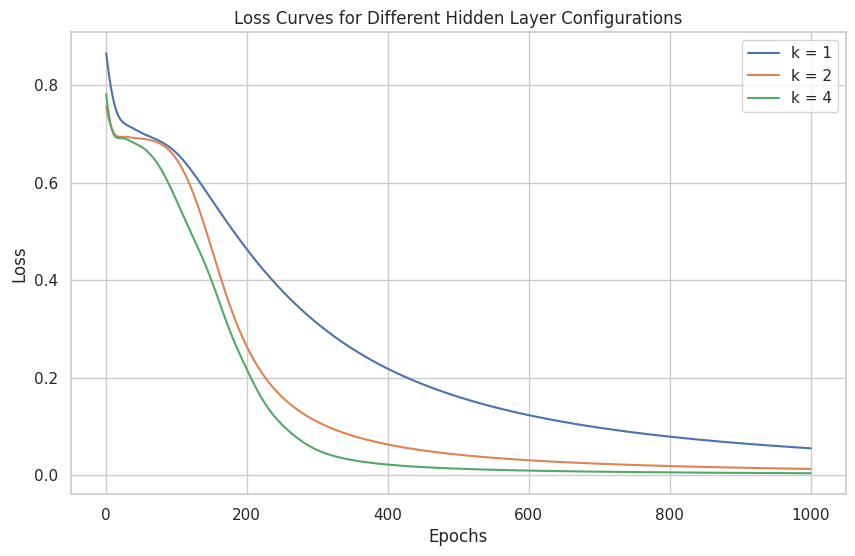
Writers: Adir Amar 209017755, Shoval Benjer 319037404

# **setup:**


To run this code, you'll need the following requirements:

Python 3.x

PyTorch

NumPy

Pandas

You can install these requirements using pip:

`!pip install torch numpy pandas`

To run the code:

1. Copy the provided code into a Python file (e.g., xor_network.py)
2. Run the file using Python:
`python xor_network.py`

If you need to run this in VLab:
Log in to your VLab account
Open a terminal
**Ensure the required packages are installed** (use the pip command above if needed)
Navigate to the directory containing your Python file
Run the file using Python as described above
The code will automatically run experiments for k=1 (with bypass), k=2, and k=4, displaying the weights, biases, loss values, and truth tables for each configuration.

Note: The code uses a low temperature (0.001) for the BTU/sigmoid function as requested in the assignment. No additional setup is required beyond having the necessary Python packages installed.

In [ ]:
!pip install torch seaborn matplotlib

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd